# 🧬 NESP: ThermoNet v2 🧬


# Utils, imports

In [1]:
import multiprocessing
import os

import Levenshtein
import numpy as np
from plotly.offline import init_notebook_mode
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm

init_notebook_mode(connected=True)
import glob
from scipy.stats import spearmanr
from pprint import pprint

import plotly.express as px
import torch as th
import pandas as pd
from scipy.stats import rankdata
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from collections import defaultdict
import copy
from torch.optim import AdamW

MULTIPROCESSING = False
BOXSIZE = 16
VOXELSIZE = 1
N_FOLDS = 10
MODELS_PATH = 'models'
DEBUG = True
DEVICE = 'cuda' if th.cuda.is_available() else 'cpu'
DESTABILIZING_MUTATIONS_ONLY = True
AUGMENT_DESTABILIZING_MUTATIONS = False
EARLY_STOPPING_PATIENCE = 30
IS_DDG_TARGET = True
WITH_PUCCI_SOURCE = True
WITH_KAGGLE_DDG_SOURCE = True

# switchers
TRAIN = False
WANDB_TRAIN_PROJECT = 'ThermoNetV2-train'
WANDB_TRAIN_NAME = 'thermonetv2-7633-v2'

OPTUNA = False
OPTUNA_WANDB_PROJECT = "ThermoNetV2-Optuna"
OPTUNA_TRIALS = 400

WANDB_SWEEP = False
WANDB_SWEEP_PROJECT = 'ThermoNetV2-sweep'

SUBMISSION = True


DEFAULT_PARAMS = {
    'SiLU': False,
    'diff_features': True,
    'LayerNorm': False,
    'GroupKFold': False,  # only use for hyperopt
    'epochs': 30,
    'AdamW': False,
}





BEST_PARAMS = {**DEFAULT_PARAMS, **{'AdamW': True,
 'C_dt_loss': 0.01,
 'OneCycleLR': False,
 'batch_size': 256,
 'AdamW_decay': 1.3994535042337082,
 'dropout_rate': 0.06297340526648805,
 'learning_rate': 0.00020503764745082723,
 'conv_layer_num': 5,
 'dropout_rate_dt': 0.3153179929570238,
 'dense_layer_size': 74.1731281147114}}



try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    WANDB_API_KEY = user_secrets.get_secret("mywabdb_api")

    print('Running in Kaggle')
    WILDTYPE_PDB = '../input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb'
    PDB_PATH = '../input/thermonet-wildtype-relaxed'
    TRAIN_FEATURES_PATH = '../input/thermonet-features/Q3214.npy'
    TRAIN_TARGETS_PATH = ''
    TEST_CSV = '../input/novozymes-enzyme-stability-prediction/test.csv'
    TEST_FEATURES_PATH = '../input/thermonet-features/nesp_features.npy'
    PUBLIC_SUBMISSIONS=[
        '../input/rmsd-from-molecular-dynamics/submission_rmsd.csv',     # LB: 0.507
        '../input/plldt-ddg-demask-sasa/deepddg-ddg.csv',                # LB: 0.451
        '../input/novo-esp-eli5-performant-approaches-lb-0-451/submission.csv',  # 0.451
        '../input/nesp-alphafold-getarea-exploration/submission.csv',                   # 0.407
    ]    
    TRAIN_FEATURES_DIR = '../input/nesp-9936-unique-mutations-voxel-features'
    

except Exception as ex:
    print('Running locally')
    WILDTYPE_PDB = 'nesp/thermonet/wildtypeA.pdb'
    PDB_PATH = 'nesp/thermonet/'
    TRAIN_FEATURES_PATH = 'data/train_features/features.npy'
    TRAIN_TARGETS_PATH = 'data/train_features/dataset.csv'
    TEST_FEATURES_PATH = 'data/nesp/nesp_features.npy'
    TEST_CSV = 'data/nesp/test.csv'
    PUBLIC_SUBMISSIONS=glob.glob('data/nesp/public_submissions/*.csv')
    TRAIN_FEATURES_DIR = 'data/train_features/'
    WANDB_API_KEY='your_key_here'

os.makedirs(MODELS_PATH, exist_ok=True)

Running in Kaggle


In [2]:
import wandb

"""
Add WANDB_API_KEY with your wandb.ai API key to run the code. 
"""
wandb.login(key=WANDB_API_KEY)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Load training data

In [3]:
def load_data():
    print("1. Loading csv datasets")
    df = pd.read_csv(f'{TRAIN_FEATURES_DIR}/dataset.csv')
    df.source = df.source.apply(eval)
    print(f'Total unique mutations: {len(df)}')

    df['features'] = df.apply(lambda r: f'{TRAIN_FEATURES_DIR}/features/{r.PDB_chain}_{r.wildtype}{r.pdb_position}{r.mutant}.npy', axis=1)
    df = df[df.features.apply(lambda v: os.path.exists(v))]

    print(f'Total mutations with features: {len(df)}')

    if not WITH_PUCCI_SOURCE:
        df = df[df.source.apply(lambda v: v != ['pucci-proteins-appendixtable1.xlsx'])]

    if not WITH_KAGGLE_DDG_SOURCE:
        df = df[df.source.apply(lambda v: v != ['ddg-xgboost-5000-mutations-200-pdb-files-lb-0-40.csv'])]

    print(f'Total mutations after filtering: {len(df)}')

    df.features = [np.load(f) for f in tqdm(df.features, desc="2. Loading features")]


    df_train = df

    if DESTABILIZING_MUTATIONS_ONLY:
        print('Keeping destabilizing mutations only')
        df_train = df_train[((df_train.ddG < 0))  & ((df_train.dT < 0) | df_train.dT.isna())].reset_index(drop=True).copy() # best for ddG
    elif AUGMENT_DESTABILIZING_MUTATIONS:
        print('Augmenting destabilizinb mutations')
        df_pos = df_train[df_train.ddG > 0].copy()
        df_neg = df_train[df_train.ddG < 0]
        print(df_pos.shape, df_neg.shape)
        df_pos.features = df_pos.features.apply(lambda f: np.concatenate([f[7:], f[:7]], axis=0))
        df_pos.ddG = -df_pos.ddG
        df_pos.dT = -df_pos.dT
        df_train = pd.concat([df_pos, df_neg], axis=0).sample(frac=1.).reset_index(drop=True)        
    return df_train

df_train = load_data()
df_train

1. Loading csv datasets
Total unique mutations: 14656
Total mutations with features: 12167
Total mutations after filtering: 12167


2. Loading features:   0%|          | 0/12167 [00:00<?, ?it/s]

Keeping destabilizing mutations only


,sequence,wildtype,pdb_position,seq_position,mutant,ddG,dT,wT,pH,source,PDB_chain,features
0,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,D,58,58,N,-0.120000,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[1.00000000e+00 1.83487193e-01 3.07613411e-...
1,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,E,25,25,A,-0.050000,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[3.38143335e-06 3.03279778e-05 3.04589878e-...
2,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,R,23,23,A,-0.763333,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[0.00000000e+00 0.00000000e+00 0.00000000e+...
3,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,R,39,39,A,-0.726667,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[0.0076158 0.09321734 0.13197631 0.0698161...
4,AAQASVVANQLIPINTALTLVMMRSEVVTPVGIPAEDIPRLVSMQV...,R,47,47,A,-0.636429,NaN,NaN,7.0,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1msiA,[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
...,...,...,...,...,...,...,...,...,...,...,...,...
7628,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,R,382,269,S,-17.400000,-5.2,NaN,7.4,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1clwA,[[[[0.00544725 0.06888345 0.3927299 0.1319893...
7629,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,T,235,122,I,-1.600000,-0.4,NaN,7.4,"[Q3421.txt, Q3214_direct.csv, Q1744_direct.csv...",1clwA,[[[[6.02426507e-04 2.46603597e-03 4.25419226e-...
7630,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,G,244,131,R,-1.330000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA,[[[[3.29420297e-02 1.07765760e-01 2.73649860e-...
7631,YSIEADKKFKYSVKLSDYPTLQDAASAAVDGLLIDRDYNFYGGETV...,R,285,172,K,-3.430000,NaN,NaN,7.4,"[dataset_S2648.csv, iStable2.0 - s3568]",1tyvA,[[[[2.24163487e-03 1.26180000e-02 7.25209257e-...


<AxesSubplot:title={'center':'Distribution of dT'}, ylabel='Frequency'>

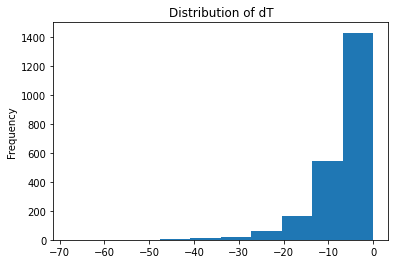

In [4]:
df_train.dT.plot.hist(title='Distribution of dT')

<AxesSubplot:title={'center':'Distribution of ddG'}, ylabel='Frequency'>

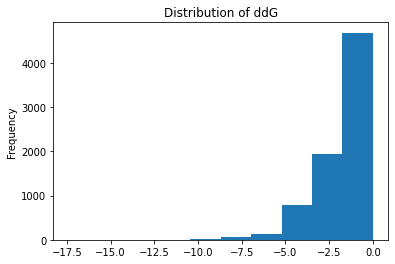

In [5]:
df_train.ddG.plot.hist(title='Distribution of ddG')

<AxesSubplot:title={'center':'ddG vs dT'}, xlabel='ddG', ylabel='dT'>

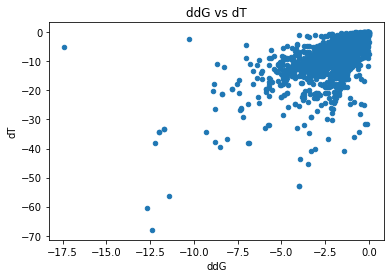

In [6]:
df_train.plot.scatter(x='ddG', y='dT', title='ddG vs dT')

<AxesSubplot:title={'center':'Mutations per sequence'}, ylabel='Frequency'>

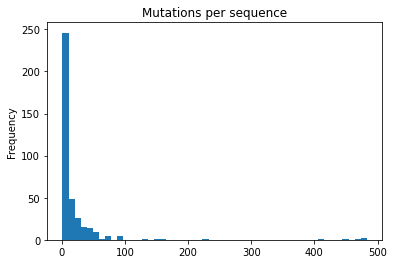

In [7]:
df_train.groupby('sequence').features.count().plot.hist(title='Mutations per sequence', bins=50)

# Plotting voxel representation of features

In the following plots we use 3D scatterplot to demonstrate training samples. 
Specifically we plot `occupancy` feature that represents probability that certain voxel is occpupied by an atom.
Recall that each training/test sample uses a combination of wildetype+mutant features. So we use the following color-coding:
* blue color represents voxels that are occupied in both wildtype and mutant structures 
* red color represents voxels that are occupied only in the mutant structure
* green color represents voxels that are occupied only in the wildtype structure

In [8]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

def plot_voxels():
    for i in [123, 124, 125, 126]:
        df = pd.DataFrame([(x, y1, z) for x in range(16) for y1 in range(16) for z in range(16)], columns=['x', 'y', 'z'])
        df['occupancy1'] = df_train.iloc[i].features[6, :, :, :].flatten() > 0.9
        df['occupancy2'] = df_train.iloc[i].features[13, :, :, :].flatten() > 0.9
        df.loc[df.occupancy1 | df.occupancy2, 'color'] = 'blue'
        df.loc[~df.occupancy1 & df.occupancy2, 'color'] = 'red'
        df.loc[df.occupancy1 & ~df.occupancy2, 'color'] = 'green'
        ddg = df_train.ddG[i]
        fig = px.scatter_3d(df.dropna(), x='x', y='y', z='z', color='color', title=f"Train idx:{i}; ddg={ddg}")
        fig.show()
        

#plot_voxels()

# Model

In [9]:
class ThermoNet2(th.nn.Module):
    def __init__(self, params):
        super().__init__()

        CONV_LAYER_SIZES = [14, 16, 24, 32, 48, 78, 128]
        FLATTEN_SIZES = [0, 5488, 5184, 4000, 3072, 2106, 1024]

        dropout_rate = params['dropout_rate']
        dropout_rate_dt = params['dropout_rate_dt']
        dense_layer_size = int(params['dense_layer_size'])
        layer_num = int(params['conv_layer_num'])
        silu = params['SiLU']

        self.params = params
        if silu:
            activation = th.nn.SiLU()
        else:
            activation = th.nn.ReLU()

        model = [
            th.nn.Sequential(
                *[th.nn.Sequential(
                    th.nn.Conv3d(in_channels=CONV_LAYER_SIZES[l], out_channels=CONV_LAYER_SIZES[l + 1], kernel_size=(3, 3, 3)),
                    activation
                ) for l in range(layer_num)]
            ),
            th.nn.MaxPool3d(kernel_size=(2,2,2)),
            th.nn.Flatten(),
        ]
        flatten_size = FLATTEN_SIZES[layer_num]
        if self.params['LayerNorm']:
            model.append(th.nn.LayerNorm(flatten_size))
        self.model = th.nn.Sequential(*model)

        self.ddG = th.nn.Sequential(
            th.nn.Dropout(p=dropout_rate),
            th.nn.Linear(in_features=flatten_size, out_features=dense_layer_size),
            activation,
            th.nn.Dropout(p=dropout_rate),
            th.nn.Linear(in_features=dense_layer_size, out_features=1)
        )
        self.dT = th.nn.Sequential(
            th.nn.Dropout(p=dropout_rate_dt),
            th.nn.Linear(in_features=flatten_size, out_features=dense_layer_size),
            activation,
            th.nn.Dropout(p=dropout_rate_dt),
            th.nn.Linear(in_features=dense_layer_size, out_features=1)
        )


    def forward(self, x):
        if self.params['diff_features']:
            x[:, 7:, ...] -= x[:, :7, ...]
        x = self.model(x)
        ddg = self.ddG(x)
        dt = self.dT(x)
        return ddg.squeeze(), dt.squeeze()

if DEBUG:
    params = copy.copy(BEST_PARAMS)
    params['diff_features'] = False
    tn2 =ThermoNet2(params)
    print([out.shape for out in tn2.forward(th.randn((2, 14, 16, 16, 16)))])
    print(tn2)

[torch.Size([2]), torch.Size([2])]
ThermoNet2(
  (model): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv3d(14, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv3d(16, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv3d(24, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): ReLU()
      )
      (3): Sequential(
        (0): Conv3d(32, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): ReLU()
      )
      (4): Sequential(
        (0): Conv3d(48, 78, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): ReLU()
      )
    )
    (1): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Flatten(start_dim=1, end_dim=-1)
  )
  (ddG): Sequential(
    (0): Dropout(p=0.06297340526648805, inplace=False)
    (1): Linear(in_features=2106, out_features=74, bias=True)
    (2): ReLU()
   

## Toy test extracting featuers

In [11]:
xx = th.randn((2, 14, 16, 16, 16)) 
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

print('==========')

tn2.ddG[1].register_forward_hook(get_activation('ddG'))
output = tn2(xx)
np.exp(activation['ddG'].numpy())

array([[0.99813724, 1.0222142 , 1.0245333 , 1.0100641 , 1.0019186 ,
        0.99606854, 1.0305263 , 1.0214044 , 1.0183047 , 0.9953565 ,
        1.0145679 , 1.0106393 , 0.9881061 , 1.0111187 , 1.0136343 ,
        0.98217994, 0.98387504, 1.0288947 , 0.9728094 , 0.99378765,
        0.9977604 , 1.0183884 , 1.0272493 , 0.97112685, 1.0118079 ,
        1.0137309 , 1.0197682 , 1.0169618 , 1.0125301 , 1.0092378 ,
        1.0128227 , 1.0117795 , 0.99701345, 1.0302719 , 1.0089905 ,
        0.9713677 , 0.97424996, 0.9929658 , 0.97521424, 1.0238795 ,
        1.0096732 , 0.99739826, 1.0016412 , 1.0037303 , 1.0061067 ,
        1.0025364 , 1.0185261 , 0.9984157 , 1.0037746 , 1.0028186 ,
        0.9674032 , 0.9854847 , 0.9801032 , 1.0404583 , 1.0122759 ,
        0.9870689 , 1.0022333 , 1.0002234 , 1.0189939 , 0.9827187 ,
        1.0211272 , 1.002656  , 0.98970664, 1.0327888 , 0.99077135,
        1.0063505 , 1.0289629 , 1.015488  , 1.0018356 , 1.0051311 ,
        1.0527976 , 1.009415  , 0.99282986, 0.99

# Dataset

In [12]:
class ThermoNet2Dataset(Dataset):
    def __init__(self, df=None, features=None):
        self.df = df
        self.features = features

    def __getitem__(self, item):
        if self.df is not None:
            r = self.df.iloc[item]
            if 'ddG' in self.df.columns:
                return th.as_tensor(r.features, dtype=th.float), th.tensor(r.ddG, dtype=th.float), th.tensor(r.dT, dtype=th.float)
            else:
                return th.as_tensor(r.features, dtype=th.float)
        else:
            return th.as_tensor(self.features[item], dtype=th.float)

    def __len__(self):
        return len(self.df) if self.df is not None else len(self.features)

if DEBUG:
    ds = ThermoNet2Dataset(df_train)
    feat, t1, t2 = next(iter(DataLoader(ds, batch_size=BEST_PARAMS['batch_size'])))
    print(feat.shape, t1.shape, t2.shape)

torch.Size([256, 14, 16, 16, 16]) torch.Size([256]) torch.Size([256])


# Train

In [13]:
def evaluate(model, dl_val, params):
    criterion = th.nn.MSELoss()
    model.eval()
    losses = []
    ddg_preds = []
    dt_preds = []
    ddg_losses = []
    dt_losses = []
    with th.no_grad():
        for x, ddg, dt in tqdm(dl_val, desc='Eval', disable=True):
            ddg_pred, dt_pred = model(x.to(DEVICE))
            ddg_preds.append(ddg_pred.cpu().numpy())
            dt_preds.append(dt_pred.cpu().numpy())
            ddg = ddg.to(DEVICE)
            dt = dt.to(DEVICE)
            not_nan_ddg = ~th.isnan(ddg)
            ddg_loss = criterion(ddg[not_nan_ddg], ddg_pred[not_nan_ddg])

            not_nan_dt = ~th.isnan(dt)
            dt_loss = criterion(dt[not_nan_dt], dt_pred[not_nan_dt])

            loss = th.stack([ddg_loss, dt_loss * params['C_dt_loss']])
            loss = loss[~th.isnan(loss)].sum()
            if not np.isnan(loss.item()):
                losses.append(loss.item())
            if not np.isnan(ddg_loss.item()):
                ddg_losses.append(ddg_loss.item())
            if not np.isnan(dt_loss.item()):
                dt_losses.append(dt_loss.item())

    return np.mean(losses), np.mean(ddg_losses), np.mean(dt_losses), np.concatenate(ddg_preds), np.concatenate(dt_preds)


def load_pytorch_model(fname, params=BEST_PARAMS):
    model = ThermoNet2(params)
    model.load_state_dict(th.load(fname))
    return model


def train_model(name, dl_train, dl_val, params, wandb_enabled=True, project='thermonetv2'):
    model = ThermoNet2(params).to(DEVICE)

    if params['AdamW']:
        def get_optimizer_params(model, encoder_lr, weight_decay=0.0):
            no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
            optimizer_parameters = [
                {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                 'lr': encoder_lr, 'weight_decay': weight_decay},
                {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                 'lr': encoder_lr, 'weight_decay': 0.0},
            ]
            return optimizer_parameters

        optimizer_parameters = get_optimizer_params(model,
                                                    encoder_lr=params['learning_rate'],
                                                    weight_decay=params['AdamW_decay'])
        optim = AdamW(optimizer_parameters, lr=params['learning_rate'])
    else:
        optim = th.optim.Adam(model.parameters(), lr=params['learning_rate'])

    scheduler = None
    if params['OneCycleLR']:
        from torch.optim.lr_scheduler import OneCycleLR
        scheduler = OneCycleLR(optim, max_lr=params['learning_rate'],
                                                     steps_per_epoch=len(dl_train), epochs=params['epochs'],
                                                     pct_start=0.)
    criterion = th.nn.MSELoss()
    best_model = None
    min_epoch = -1
    val_losses = defaultdict(lambda: [])

    run = None
    if wandb_enabled:
        run = wandb.init(project=project, name=name, mode='online' if wandb_enabled else 'disabled')

    with tqdm(range(params['epochs']), desc='Epoch') as prog:
        min_loss = np.inf
        for epoch in prog:
            model.train()
            for x, ddg, dt in tqdm(dl_train, desc='Train', disable=True):
                ddg_pred, dt_pred = model(x.to(DEVICE))
                ddg = ddg.to(DEVICE)
                dt = dt.to(DEVICE)
                loss = None
                any_ddg = ~th.isnan(ddg)
                if th.any(any_ddg):
                    loss = criterion(ddg[any_ddg], ddg_pred[any_ddg])
                any_dt = ~th.isnan(dt)
                if th.any(any_dt):
                    dt_loss = criterion(dt[any_dt], dt_pred[any_dt])
                    if loss is None:
                        loss = dt_loss * params['C_dt_loss']
                    else:
                        loss += dt_loss * params['C_dt_loss']
                optim.zero_grad()
                loss.backward()
                optim.step()
                if scheduler is not None:
                    scheduler.step()

            eval_loss, eval_ddg_loss, eval_dt_loss = evaluate(model, dl_val, params)[:3]
            val_losses['loss'].append(eval_loss)
            val_losses['ddg_loss'].append(eval_ddg_loss)
            val_losses['dt_loss'].append(eval_dt_loss)
            if run is not None:
                run.log({'val_loss': eval_loss, 'val_ddg_loss': eval_ddg_loss, 'val_dt_loss': eval_dt_loss,
                         'lr': scheduler.get_last_lr()[0] if scheduler is not None else params['learning_rate']})
            if eval_loss < min_loss:
                min_loss = eval_loss
                min_epoch = epoch
                best_model = copy.deepcopy(model)
            prog.set_description(
                f'Epoch: {epoch}; Val MSE:{eval_loss:.02f}; Min Val MSE:{min_loss:.02f}; ddg loss:{eval_ddg_loss:.02f}; dT loss:{eval_dt_loss:.02f}')
            if epoch - min_epoch > EARLY_STOPPING_PATIENCE:
                print('Early stopping')
                break

    if run is not None:
        art = wandb.Artifact("thermonet2", type="model")
        fname = f'{MODELS_PATH}/{name}.pt'
        th.save(model.state_dict(), fname)
        art.add_file(fname)
        run.log_artifact(art)
        run.finish()
    return best_model, val_losses


def run_train(name, params, project='thermonetv2'):
    os.makedirs(MODELS_PATH, exist_ok=True)
    val_losses = []
    thermonet_models = []
    kfold = GroupKFold(N_FOLDS)
    if params['GroupKFold']:
        groups = df_train.sequence
    else:
        groups = range(len(df_train))
    for fold, (train_idx, val_idx) in enumerate(
            tqdm(kfold.split(df_train, groups=groups), total=N_FOLDS, desc="Folds")):
        exp_name = f'{name}-{fold}'
        fname = f'{MODELS_PATH}/{exp_name}.pt'
        ds_train = ThermoNet2Dataset(df_train.loc[train_idx])
        ds_val = ThermoNet2Dataset(df_train.loc[val_idx])

        batch_size = params['batch_size']
        dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
        dl_val = DataLoader(ds_val, batch_size=64, pin_memory=True, drop_last=True)

        model, losses = train_model(exp_name, dl_train, dl_val, params, wandb_enabled=True, project=project)
        val_losses.append(losses)
        thermonet_models.append(model)

    d = pd.DataFrame([{k: np.min(v) for k, v in l.items()} for l in val_losses]).mean().to_dict()
    with wandb.init(project=f'{project}-CV', name=name) as run:
        run.log(d)
    return thermonet_models, d


if TRAIN:
    params = copy.copy(BEST_PARAMS)
    thermonet_models = run_train(WANDB_TRAIN_NAME, params, project=WANDB_TRAIN_PROJECT)[0]

In [14]:
#%wandb -h 800 vslaykovsky/ThermoNetV2-train

# Optuna Hyperparameter Optimization

In [15]:
if OPTUNA:

    import optuna
    from optuna.integration.wandb import WeightsAndBiasesCallback

    wandbc = WeightsAndBiasesCallback(wandb_kwargs={"project": OPTUNA_WANDB_PROJECT}, as_multirun=True)

    @wandbc.track_in_wandb()
    def objective(trial):
        params = copy.copy(DEFAULT_PARAMS)
        params['conv_layer_num'] = trial.suggest_int('conv_layer_num', 3, 6)
        params['AdamW'] = trial.suggest_categorical('AdamW', [True, False])
        if params['AdamW']:
            params['AdamW_decay'] = trial.suggest_float('AdamW_decay', 0.001, 100, log=True)
        params['dense_layer_size'] = trial.suggest_int('dense_layer_size', 16, 128, log=True)

        params['dropout_rate'] = trial.suggest_float('dropout_rate', 0., 0.7, log=False)
        params['dropout_rate_dt'] = trial.suggest_float('dropout_rate_dt', 0., 0.7, log=False)
        params['learning_rate'] = trial.suggest_float('learning_rate', 5e-6, 1e-3, log=True)
        params['batch_size'] = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512])
        params['C_dt_loss'] = trial.suggest_categorical('C_dt_loss', [0, 0.01, 0.1, 1.])
        params['GroupKFold'] = True # works best for hyperparameter optimization
        params['OneCycleLR'] = trial.suggest_categorical('OneCycleLR', [True, False])

        print('params', params)
        # --------------- train --------------
        kfold = GroupKFold(5)
        for train_idx, val_idx in kfold.split(df_train, groups=df_train.sequence):
            ds_train = ThermoNet2Dataset(df_train.loc[train_idx])
            ds_val = ThermoNet2Dataset(df_train.loc[val_idx])
            batch_size = params['batch_size']
            dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
            dl_val = DataLoader(ds_val, batch_size=64, pin_memory=True, shuffle=True, drop_last=True)
            _, losses = train_model("optuna", dl_train, dl_val, params, wandb_enabled=False)
            return np.min(losses['ddg_loss' if IS_DDG_TARGET else 'dt_loss'])


    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=OPTUNA_TRIALS, callbacks=[wandbc])

In [16]:
#%wandb -h 1200 vslaykovsky/ThermoNetV2-Optuna-fireprotdb

# Wandb Sweeps Hyperparameter Optimization

Wandb sweeps are executed in 2 steps:
1. Create sweep configuration in your Wandb project. This is done with `wandb.sweep` call below.
2. Once you got your sweep id, pass it to your agents. Agents run tests using configuration passed from Wandb servers using `wandb.agent` call.

See more info on Wandb sweeps here https://docs.wandb.ai/guides/sweeps

In [17]:
# Set your sweep_id below to start optimization
#%env SWEEP_ID=xxxxx   

In [18]:
if WANDB_SWEEP:
    import wandb
    sweep_id = os.environ.get('SWEEP_ID')
    print('wandb sweep ', sweep_id)

    if sweep_id is None:
        """
        First run. Generate sweep_id. 
        """
        sweep_id = wandb.sweep(sweep={
            'method': 'bayes',
            'name': 'thermonet2-sweep',
            'metric': {'goal': 'minimize', 'name': 'val_ddg_loss'},
            'parameters':
                {
                    'conv_layer_num': {'values': [3, 4, 5, 6]},
                    'AdamW': {'values': [True, False]},
                    'AdamW_decay': {'min': 0.01, 'max': 5, 'distribution': 'log_uniform_values'},
                    'dense_layer_size': {'min': 16, 'max': 128, 'distribution': 'log_uniform_values'},
                    'dropout_rate': {'min': 0., 'max': 0.8, 'distribution': 'uniform'},
                    'dropout_rate_dt': {'min': 0., 'max': 0.8, 'distribution': 'uniform'},
                    'learning_rate': {'min': 1e-5, 'max': 3e-3, 'distribution': 'log_uniform_values'},
                    'batch_size': {'values': [64, 128, 256, 512]},
                    'OneCycleLR': {'values': [True, False]},
                    'C_dt_loss': {'values': [0, 0.003, 0.01, 0.03]},
                }
        }, project=WANDB_SWEEP_PROJECT)
        print('Generated sweep id', sweep_id)
    else:
        """
        Agent run. Use sweep_id generated above. 
        """
        def wandb_callback():
            with wandb.init() as run:
                params = copy.copy(DEFAULT_PARAMS)
                params['conv_layer_num'] = run.config.conv_layer_num
                params['AdamW'] = run.config.AdamW
                params['AdamW_decay'] = run.config.AdamW_decay
                params['dense_layer_size'] = int(run.config.dense_layer_size)
                params['dropout_rate'] = run.config.dropout_rate
                params['dropout_rate_dt'] = run.config.dropout_rate_dt
                params['learning_rate'] = run.config.learning_rate
                params['batch_size'] = run.config.batch_size
                params['OneCycleLR'] = run.config.OneCycleLR
                params['C_dt_loss'] = run.config.C_dt_loss
                params['GroupKFold'] = True  # only for hyperparameter optimization
                print('params', params)

                # --------------- train --------------
                kfold = GroupKFold(5)
                for train_idx, val_idx in kfold.split(df_train, groups=df_train.sequence):
                    ds_train = ThermoNet2Dataset(df_train.loc[train_idx])
                    ds_val = ThermoNet2Dataset(df_train.loc[val_idx])
                    batch_size = params['batch_size']
                    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, pin_memory=True)
                    dl_val = DataLoader(ds_val, batch_size=512, pin_memory=True, shuffle=True)
                    _, losses = train_model(0, dl_train, dl_val, params, wandb_enabled=False)
                    for epoch in range(len(losses['ddg_loss'])):
                        run.log({
                            'epoch': epoch,
                            'val_loss': losses['loss'][epoch],
                            'val_ddg_loss': losses['ddg_loss'][epoch],
                            'val_dt_loss': losses['dt_loss'][epoch],
                        })
                    break



        # Start sweep job.
        wandb.agent(sweep_id, project=WANDB_SWEEP_PROJECT, function=wandb_callback, count=100000)

In [19]:
#%wandb -h 1200 vslaykovsky/ThermoNetV2-fireprot-sweep/sweeps/vzyvxo1a

# Submission

All models are stored in Wandb, so downloading models to the localhost here.

In [20]:
import wandb
def collect_wandb_models(name):
    runs = wandb.Api().runs(
        path='vslaykovsky/ThermoNetV2-train',
    )
    with tqdm(runs, desc='Downloading artefacts') as prog:
        for run in prog:
            art = run.logged_artifacts()
            if len(art) > 0:
                if name in run.name:
                    prog.set_description(run.name)
                    art[0].download()


if SUBMISSION:
    collect_wandb_models(WANDB_TRAIN_NAME)

In [21]:
def gen_mutations(name, df,
                  wild="VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQ""RVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGT""NAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKAL""GSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"):
    result = []
    for _, r in df.iterrows():
        ops = Levenshtein.editops(wild, r.protein_sequence)
        assert len(ops) <= 1
        if len(ops) > 0 and ops[0][0] == 'replace':
            idx = ops[0][1]
            result.append([ops[0][0], idx + 1, wild[idx], r.protein_sequence[idx]])
        elif len(ops) == 0:
            result.append(['same', 0, '', ''])
        elif ops[0][0] == 'insert':
            assert False, "Ups"
        elif ops[0][0] == 'delete':
            idx = ops[0][1]
            result.append(['delete', idx + 1, wild[idx], '-'])
        else:
            assert False, "Ups"

    df = pd.concat([df, pd.DataFrame(data=result, columns=['op', 'idx', 'wild', 'mutant'])], axis=1)
    df['mut'] = df[['wild', 'idx', 'mutant']].astype(str).apply(lambda v: ''.join(v), axis=1)
    df['name'] = name
    return df

if SUBMISSION:
    df_test = gen_mutations('wildtypeA', pd.read_csv(TEST_CSV))
    display(df_test)

,seq_id,protein_sequence,pH,data_source,op,idx,wild,mutant,mut,name
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,E,L17E,wildtypeA
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,K,L17K,wildtypeA
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,delete,17,L,-,L17-,wildtypeA
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,C,K18C,wildtypeA
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,F,K18F,wildtypeA
...,...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,I,A16I,wildtypeA
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,L,A16L,wildtypeA
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,N,A16N,wildtypeA
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,P,A16P,wildtypeA


In [22]:
def predict(model:ThermoNet2, test_features):
    with th.no_grad():
        model.eval()
        dl = DataLoader(ThermoNet2Dataset(features=test_features), batch_size=64)
        if IS_DDG_TARGET:
            return np.concatenate(
                [model.forward(x)[0].numpy() for x in tqdm(dl, desc='ThermoNet2 ddg predict', disable=True)])
        else:
            return np.concatenate(
                [model.forward(x)[1].numpy() for x in tqdm(dl, desc='ThermoNet2 dt predict', disable=True)])

### ThermoNet Predictions

In [23]:
if SUBMISSION:        
    thermonet_models = [load_pytorch_model(f) for f in tqdm(glob.glob(f'artifacts/*/{WANDB_TRAIN_NAME}*.pt'), desc=f'Loading models {WANDB_TRAIN_NAME}')]

    test_features = np.load(TEST_FEATURES_PATH)
    test_ddg = np.stack([predict(model, test_features) for model in tqdm(thermonet_models, desc='Fold prediction')])
    test_ddg = np.mean(test_ddg, axis=0).flatten()

    # replacement mutations
    df_test.loc[df_test.op == 'replace', 'ddg'] = np.exp(test_ddg) ##
    # deletion mutations
    df_test.loc[df_test['op'] == "delete", 'ddg'] = df_test[df_test["op"]=="replace"]["ddg"].quantile(q=0.333) #0.25
    # no mutations
    df_test.loc[df_test['op'] == "same", 'ddg'] = 0.  

    df_test.rename(columns={'ddg': 'tm'})[['seq_id', 'tm']].to_csv('submission.csv', index=False)
    !head submission.csv

Loading models thermonetv2-7633-v2:   0%|          | 0/10 [00:00<?, ?it/s]

Fold prediction:   0%|          | 0/10 [00:00<?, ?it/s]

seq_id,tm
31390,0.53406525
31391,0.5943172
31392,0.17083429
31393,0.28620416
31394,0.25924572
31395,0.09343416
31396,0.3146236
31397,0.3482143
31398,0.47220054


## look up at prediction distrbuation

<AxesSubplot:>

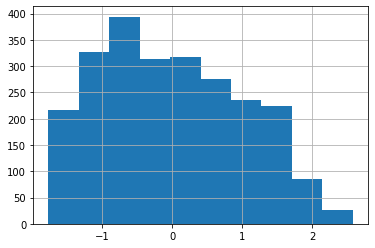

In [24]:
m = df_test.ddg.mean()
s = df_test.ddg.std()

((df_test.ddg - m) / s).hist()

<AxesSubplot:>

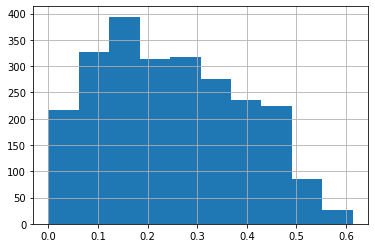

In [25]:
df_test.ddg.hist()

<AxesSubplot:>

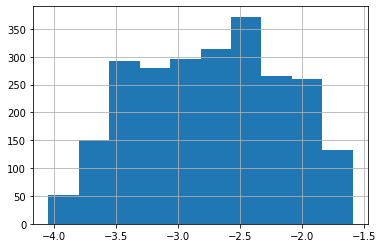

In [26]:
m = np.exp(df_test.ddg).mean()
s = np.exp(df_test.ddg).std()

((np.exp(-df_test.ddg) - m) / s).hist()

<AxesSubplot:>

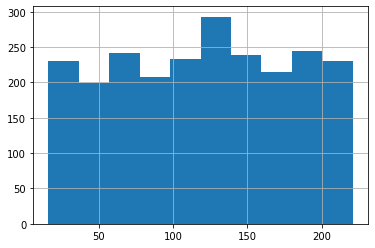

In [27]:
df_test[df_test.op == 'replace'].idx.hist()

# Ensemble

Ensembling ThermoNetV2 with top public solutions

In [28]:
if SUBMISSION:
    
    def ranked(f):
        return rankdata(pd.read_csv(f).tm)
    
    pred = 0.7 * ranked('../input/rmsd-from-molecular-dynamics/submission_rmsd.csv')+\
        0.3 * (ranked('../input/plldt-ddg-demask-sasa/deepddg-ddg.csv')+        \
        ranked('../input/novo-esp-eli5-performant-approaches-lb-0-451/submission.csv')+ \
        ranked('../input/nesp-alphafold-getarea-exploration/submission.csv') + \
        ranked('submission.csv'))
    
    
    df = pd.read_csv('../input/novozymes-enzyme-stability-prediction/sample_submission.csv')
    df.tm = pred

    
    # equally weighted ensemble with https://www.kaggle.com/code/shlomoron/nesp-relaxed-rosetta-scores
    df.tm = rankdata(df.tm) + ranked('../input/nesp-relaxed-rosetta-scores/submission_rosetta_scores')

    
    df.to_csv('ensemble_submission.csv', index=False)
    !head ensemble_submission.csv    

seq_id,tm
31390,4574.0
31391,4595.0
31392,2459.5
31393,3428.0
31394,2254.0
31395,3447.0
31396,4072.0
31397,3959.0
31398,4064.0


<AxesSubplot:>

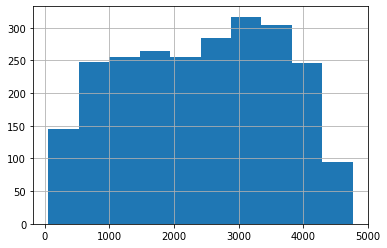

In [30]:
df.tm.hist()

In [31]:
!rm -rf wandb 


<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>


## Extract Featuers

In [32]:
def predict_representation(model:ThermoNet2, features):
    with th.no_grad():
        model.eval()
        model.ddG[1].register_forward_hook(get_activation('ddG'))
        dl = DataLoader(ThermoNet2Dataset(features=features), batch_size=64, shuffle=False)
        preds = []
        embeddings = []
        if IS_DDG_TARGET:
            for x in tqdm(dl, desc='ThermoNet2 ddg predict', disable=True):
                out = model.forward(x)[0].numpy()
                emb = activation['ddG'].numpy()
                
                preds.append(out)
                embeddings.append(emb)
                
            return np.concatenate(preds), np.concatenate(embeddings)
        else:
            return np.concatenate(
                [model.forward(x)[1].numpy() for x in tqdm(dl, desc='ThermoNet2 dt predict', disable=True)])
        

In [33]:
train_embeddings = np.stack([predict_representation(model, df_train.features)[1] for model in tqdm(thermonet_models, desc='Fold embeddings')])
test_embeddings = np.stack([predict_representation(model, test_features)[1] for model in tqdm(thermonet_models, desc='Fold embeddings')])

Fold embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

Fold embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
train_embeddings = np.mean(train_embeddings, axis=0)
test_embeddings = np.mean(test_embeddings, axis=0)

In [36]:
temp = pd.DataFrame(train_embeddings)
del train_embeddings
temp.columns = ['Feature_' + str(x) for x in temp.columns]
temp['pH'] = df_train.pH
temp['ddG'] = df_train.ddG
temp

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_66,Feature_67,Feature_68,Feature_69,Feature_70,Feature_71,Feature_72,Feature_73,pH,ddG
0,-0.072005,0.054640,0.000721,0.148273,-0.149826,0.078101,0.189790,-0.057905,0.413718,-0.075973,...,-0.203331,-0.057842,-0.032287,0.002498,0.170392,-0.091962,0.032287,0.129016,7.0,-0.120000
1,-0.114912,0.181571,0.008787,-0.163736,-0.136503,0.019589,0.420051,0.067364,0.398717,0.110628,...,-0.267294,-0.093023,0.047352,0.014710,0.367447,-0.169186,0.032803,0.267416,7.0,-0.050000
2,-0.052098,0.125368,0.047008,-0.072815,-0.139995,0.115819,0.407477,0.000864,0.500615,0.102248,...,-0.268959,-0.050000,0.025161,0.058897,0.394814,-0.195326,0.064226,0.323430,7.0,-0.763333
3,-0.088951,0.079763,0.063724,-0.000677,-0.179926,0.115311,0.346412,-0.088401,0.638507,-0.028812,...,-0.286954,-0.019479,0.011579,0.008578,0.388661,-0.157895,-0.013415,0.265267,7.0,-0.726667
4,0.000678,0.143357,0.083710,0.271115,-0.203492,0.124344,0.360003,0.034061,0.544639,0.000547,...,-0.254983,-0.027322,-0.003127,0.043420,0.418060,-0.152949,0.055713,0.258682,7.0,-0.636429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7628,-0.072268,0.302509,0.224519,-0.162489,-0.274806,0.175007,0.688536,0.040339,0.788029,0.035798,...,-0.429470,-0.023502,0.264002,0.097870,0.791310,-0.211333,0.021034,0.506409,7.4,-17.400000
7629,-0.132701,0.113642,0.065650,-0.041131,-0.137971,0.015196,0.339341,0.028714,0.470997,0.006662,...,-0.244154,-0.033750,0.057778,0.065848,0.376001,-0.114471,0.020873,0.276370,7.4,-1.600000
7630,-0.076986,0.270557,0.078082,0.206409,-0.287326,0.191581,0.558288,0.053820,0.630622,-0.090985,...,-0.426915,-0.171217,0.219604,0.043252,0.525314,-0.084884,-0.087347,0.304581,7.4,-1.330000
7631,-0.020900,0.194552,0.242053,-0.048290,-0.130905,0.237383,0.684202,0.173639,0.724058,0.075118,...,-0.516116,-0.131201,0.395741,0.059489,0.586187,-0.078776,-0.085858,0.603059,7.4,-3.430000


In [37]:
temp_test = pd.DataFrame(test_embeddings)
del test_embeddings
temp_test.columns = ['Feature_' + str(x) for x in temp_test.columns]
temp_test['pH'] = df_test.pH
temp_test

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_65,Feature_66,Feature_67,Feature_68,Feature_69,Feature_70,Feature_71,Feature_72,Feature_73,pH
0,-0.084459,-0.026885,-0.066380,0.202190,-0.178873,0.072582,0.186715,-0.052384,0.410632,-0.096543,...,0.216891,-0.301991,-0.166622,-0.126621,-0.079262,0.085587,-0.199071,-0.069436,0.076556,8
1,-0.022793,0.037002,-0.019726,0.128705,-0.126028,0.093528,0.172319,-0.037679,0.340762,-0.034207,...,0.170378,-0.172720,-0.079020,-0.039043,-0.024425,0.126503,-0.093903,0.011688,0.083112,8
2,-0.090536,0.137523,-0.045080,-0.039468,-0.159244,0.024314,0.417887,0.160386,0.386842,0.136017,...,0.376756,-0.285730,-0.172207,0.029849,0.013812,0.360105,-0.166581,0.007572,0.297937,8
3,-0.114746,0.203190,-0.024479,-0.022437,-0.196037,-0.012894,0.437524,0.140242,0.377436,0.120237,...,0.435795,-0.306361,-0.129349,0.003795,0.032822,0.375659,-0.209701,0.070572,0.302170,8
4,-0.095340,0.321755,0.124833,-0.006407,-0.253002,0.098847,0.743992,0.255347,0.621117,0.141801,...,0.761351,-0.452124,-0.160926,0.181181,0.090376,0.663819,-0.256839,0.058921,0.522836,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,-0.053898,0.025237,-0.026688,0.069742,-0.119004,0.094276,0.185505,-0.083937,0.399734,-0.023628,...,0.152667,-0.163169,-0.080963,-0.089290,-0.049301,0.140201,-0.082838,-0.005860,0.054151,8
2331,-0.039688,0.050690,-0.025871,0.083275,-0.129636,0.101502,0.204827,-0.087228,0.401726,-0.021885,...,0.157496,-0.176745,-0.080481,-0.096171,-0.045688,0.164388,-0.095037,-0.001882,0.062465,8
2332,-0.048336,0.049606,-0.015142,0.093660,-0.137090,0.104992,0.215404,-0.087009,0.455442,-0.017594,...,0.163167,-0.176295,-0.077581,-0.076251,-0.045017,0.181926,-0.083377,-0.003905,0.065020,8
2333,-0.059512,0.000451,0.027606,0.074794,-0.154436,0.116661,0.210791,-0.092588,0.421750,-0.042876,...,0.211487,-0.251206,-0.101594,-0.011223,-0.020044,0.197060,-0.107699,-0.015949,0.139598,8


## Xgboost

In [38]:
def objective_regressor(X_train, y_train, X_val, y_val, target_value, trial):
    """It tries to find the best hyper-parameters for XGBOOST model for given task

        Details:
            It uses OPTUNA library which is based on Baseian-optimization to tune the hyper-params.

        Args:
            X_train: training data
            X_test: testing data
            y_tain: training label
            y_val: validation label
            trail: object of optuna for optimizing the task in hand

        Returns:
            best score till now

    """
    if ((target_value)):
        tree_methods = ['approx', 'hist', 'exact']
#         tree_methods = ['gpu_hist']
        boosting_lists = ['gbtree', 'gblinear']
        objective_list_reg = ['reg:squarederror']  # 'reg:gamma', 'reg:tweedie'
        boosting = trial.suggest_categorical('boosting', boosting_lists),
        tree_method = trial.suggest_categorical('tree_method', tree_methods),
        n_estimator = trial.suggest_int('n_estimators',20, 500, 10),
        max_depth = trial.suggest_int('max_depth', 10, 1000),
        reg_alpha = trial.suggest_int('reg_alpha', 1,10),
        reg_lambda = trial.suggest_int('reg_lambda', 1,10),
        min_child_weight = trial.suggest_int('min_child_weight', 1,5),
        gamma = trial.suggest_int('gamma', 1, 5),
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        objective = trial.suggest_categorical('objective', objective_list_reg),
        colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.8, 1, 0.05),
        colsample_bynode = trial.suggest_discrete_uniform('colsample_bynode', 0.8, 1, 0.05),
        colsample_bylevel = trial.suggest_discrete_uniform('colsample_bylevel', 0.8, 1, 0.05),
        subsample = trial.suggest_discrete_uniform('subsample', 0.7, 1, 0.05),
        nthread = -1
        
        
    xgboost_tune = xgb.XGBRegressor(
        tree_method=tree_method[0],
        boosting=boosting[0],
        reg_alpha=reg_alpha[0],
        reg_lambda=reg_lambda[0],
        gamma=gamma[0],
        objective=objective[0],
        colsample_bynode=colsample_bynode[0],
        colsample_bylevel=colsample_bylevel[0],
        n_estimators=n_estimator[0],
        max_depth=max_depth[0],
        min_child_weight=min_child_weight[0],
        learning_rate=learning_rate[0],
        subsample=subsample[0],
        colsample_bytree=colsample_bytree[0],
        eval_metric='rmsle',
        n_jobs=nthread,
        random_state=SEED)
    
    xgboost_tune.fit(X_train, y_train)
    pred_val = xgboost_tune.predict(X_val)
    
    return np.sqrt(mean_squared_error(y_val, pred_val))

In [39]:
train_data = temp.copy()

In [40]:
feature_cols = temp_test.columns.to_list()

In [41]:
from sklearn.model_selection import train_test_split
train_keys, valid_keys = train_test_split(
    train_data[feature_cols + ['ddG']].drop_duplicates().reset_index(drop = True), 
    test_size=0.1, 
    random_state=123)

print(len(train_keys), len(valid_keys))

6869 764


In [42]:
df_train = train_data[train_data.index.isin(train_keys.index.tolist())].reset_index(drop = True)
df_valid = train_data[train_data.index.isin(valid_keys.index.tolist())].reset_index(drop = True)
print(df_train.shape[0], df_valid.shape[0])

6869 764


In [43]:
# XGBoost model
X_train = df_train[feature_cols]
y_train = df_train[['ddG']]
X_valid = df_valid[feature_cols]
y_valid = df_valid[['ddG']]

print(X_train.shape)
X_train.isnull().sum().reset_index().sort_values(by = 0, ascending = False)

(6869, 75)


,index,0
74,pH,1243
56,Feature_56,0
54,Feature_54,0
53,Feature_53,0
52,Feature_52,0
...,...,...
24,Feature_24,0
23,Feature_23,0
22,Feature_22,0
21,Feature_21,0


#### Training

In [44]:
import optuna
from optuna.samplers import TPESampler
SEED = 123
import xgboost as xgb
import functools
from functools import partial
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score


study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=SEED))
study.optimize(
    functools.partial(objective_regressor, X_train, y_train, X_valid, y_valid,'trial'),
            timeout=500)

model_xgb = xgb.XGBRegressor(**study.best_params, random_state=SEED)
model_xgb.fit(X_train,y_train)

[I 2022-12-12 15:51:10,501] A new study created in memory with name: no-name-2cc8e268-649c-48d6-93a9-cef09eac44cb
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning:

suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning:

suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/opt/conda/lib/pyth

[15:51:12] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-12-12 15:51:58,949] Trial 0 finished with value: 1.2056597837831602 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'n_estimators': 220, 'max_depth': 981, 'reg_alpha': 7, 'reg_lambda': 5, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.08882097529918738, 'objective': 'reg:squarederror', 'colsample_bytree': 0.9, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.8500000000000001, 'subsample': 0.95}. Best is trial 0 with value: 1.2056597837831602.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning:

suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

[15:51:58] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-12-12 15:53:32,066] Trial 1 finished with value: 1.1804845727863411 and parameters: {'boosting': 'gbtree', 'tree_method': 'exact', 'n_estimators': 430, 'max_depth': 727, 'reg_alpha': 7, 'reg_lambda': 8, 'min_child_weight': 2, 'gamma': 2, 'learning_rate': 0.01981423503611216, 'objective': 'reg:squarederror', 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.9500000000000001, 'colsample_bylevel': 0.8, 'subsample': 0.85}. Best is trial 1 with value: 1.1804845727863411.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning:

suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

[15:53:32] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-12-12 15:55:56,070] Trial 2 finished with value: 1.1961928561355748 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'n_estimators': 450, 'max_depth': 945, 'reg_alpha': 6, 'reg_lambda': 7, 'min_child_weight': 1, 'gamma': 2, 'learning_rate': 0.034649848871713455, 'objective': 'reg:squarederror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.9, 'subsample': 1.0}. Best is trial 1 with value: 1.1804845727863411.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning:

suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

[15:55:56] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-12-12 15:55:59,233] Trial 3 finished with value: 1.1717641877254839 and parameters: {'boosting': 'gblinear', 'tree_method': 'hist', 'n_estimators': 280, 'max_depth': 349, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 4, 'gamma': 5, 'learning_rate': 0.04613970054195258, 'objective': 'reg:squarederror', 'colsample_bytree': 0.9500000000000001, 'colsample_bynode': 0.9, 'colsample_bylevel': 0.9500000000000001, 'subsample': 0.8999999999999999}. Best is trial 3 with value: 1.1717641877254839.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning:

suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/op

[15:55:59] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-12-12 15:56:14,024] Trial 4 finished with value: 1.1873792759131516 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'n_estimators': 300, 'max_depth': 104, 'reg_alpha': 9, 'reg_lambda': 7, 'min_child_weight': 4, 'gamma': 1, 'learning_rate': 0.05934357497562095, 'objective': 'reg:squarederror', 'colsample_bytree': 0.9, 'colsample_bynode': 0.8, 'colsample_bylevel': 0.8, 'subsample': 0.8999999999999999}. Best is trial 3 with value: 1.1717641877254839.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning:

suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

[15:56:14] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-12-12 15:58:21,589] Trial 5 finished with value: 1.2240795788812495 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'n_estimators': 430, 'max_depth': 364, 'reg_alpha': 1, 'reg_lambda': 4, 'min_child_weight': 2, 'gamma': 4, 'learning_rate': 0.19723829585832534, 'objective': 'reg:squarederror', 'colsample_bytree': 0.8500000000000001, 'colsample_bynode': 0.9500000000000001, 'colsample_bylevel': 0.9, 'subsample': 0.8999999999999999}. Best is trial 3 with value: 1.1717641877254839.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning:

suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/o

[15:58:21] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-12-12 15:59:35,740] Trial 6 finished with value: 1.1823863638421364 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'n_estimators': 340, 'max_depth': 114, 'reg_alpha': 2, 'reg_lambda': 4, 'min_child_weight': 4, 'gamma': 5, 'learning_rate': 0.05245711488130105, 'objective': 'reg:squarederror', 'colsample_bytree': 1.0, 'colsample_bynode': 0.8500000000000001, 'colsample_bylevel': 0.8500000000000001, 'subsample': 0.7999999999999999}. Best is trial 3 with value: 1.1717641877254839.


[15:59:35] WARNING: ../src/learner.cc:627: 
Parameters: { "boosting" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', boosting='gblinear',
             callbacks=None, colsample_bylevel=0.9500000000000001,
             colsample_bynode=0.9, colsample_bytree=0.9500000000000001,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.04613970054195258, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=349, max_leaves=0,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=280, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=123, reg_alpha=4, ...)

#### Evaluate

In [45]:
label = 'ddG'

In [46]:
import joblib

print('\nTrain data performance:')
y_predicted = model_xgb.predict(X_train)
print('RMSE: ', np.sqrt(mean_squared_error(df_train[label], model_xgb.predict(X_train))))
print('\nValidation data performance:')
y_predicted = model_xgb.predict(X_valid)
print('RMSE: ', np.sqrt(mean_squared_error(df_valid[label], model_xgb.predict(X_valid))))

print("Saving model .. ",end=" ")
joblib.dump(model_xgb,"XGBoost_model.pkl")


Train data performance:
RMSE:  0.908594624445433

Validation data performance:
RMSE:  1.1717641877254839
Saving model ..  

['XGBoost_model.pkl']

In [47]:
temp = pd.DataFrame(model_xgb.feature_importances_)
temp['Feature'] = X_train.columns.tolist()
temp.columns = ['Feature importance','Feature']
temp[temp['Feature importance']>0][['Feature importance','Feature']].sort_values(by = 'Feature importance', ascending = False).reset_index(drop = True)

,Feature importance,Feature
0,0.244355,Feature_52
1,0.083870,Feature_50
2,0.072988,Feature_70
3,0.067985,Feature_54
4,0.055538,Feature_63
...,...,...
70,0.003919,Feature_26
71,0.003903,Feature_23
72,0.003832,Feature_45
73,0.003754,Feature_13


In [48]:
df_test

,seq_id,protein_sequence,pH,data_source,op,idx,wild,mutant,mut,name,ddg
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,E,L17E,wildtypeA,0.534065
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,K,L17K,wildtypeA,0.594317
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,delete,17,L,-,L17-,wildtypeA,0.170834
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,C,K18C,wildtypeA,0.286204
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,F,K18F,wildtypeA,0.259246
...,...,...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,I,A16I,wildtypeA,0.597888
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,L,A16L,wildtypeA,0.572528
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,N,A16N,wildtypeA,0.561964
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,P,A16P,wildtypeA,0.500168


### Xgboost predictions

In [49]:
xgboost_pred = model_xgb.predict(temp_test)

# replacement mutations
df_test.loc[df_test.op == 'replace', 'xddg'] = np.exp(xgboost_pred)
# deletion mutations
df_test.loc[df_test['op'] == "delete", 'xddg'] = df_test[df_test["op"]=="replace"]["xddg"].quantile(q=0.333) #0.25
# no mutations
df_test.loc[df_test['op'] == "same", 'xddg'] = 0

df_test.rename(columns={'xddg': 'tm'})[['seq_id', 'tm']].to_csv('xgbsubmission.csv', index=False)

### Ensamble all

In [50]:
df_test['tm'] = 0.15 * rankdata(df_test[['xddg']]) + 0.85 * rankdata(df.tm)

df_test[['seq_id', 'tm']].to_csv('ensamble_ensamble_sub.csv', index=False)

Next step:

- ensamble with different featuers and submit.